<a href="https://colab.research.google.com/github/roscoekerby/artificial-intelligence/blob/main/Resnet_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt

In [121]:
# import os
# import pandas as pd
# from torchvision.io import read_image

# class CustomImageDataset(Dataset):
#     def __init__(self, img_dir, transform=None, target_transform=None):
#       self.img_labels = []
      
#       for f in os.listdir(img_dir):
#         if f.lower().endswith(('.png', '.jpg', '.jpeg')):
#           self.img_labels.append(f.split("_")[1])

#       self.img_dir = img_dir
#       self.transform = transform
#       self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [122]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob
from tqdm import tqdm

import os

In [123]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = '/content/Cow-Identification-1/train' 
test_data_path = '/content/Cow-Identification-1/test'

train_image_paths = []
# train_image_paths.append(train_data_path) #to store image paths in list
classes = [] #to store class values

for f in os.listdir(train_data_path):
      if f.lower().endswith(('.png', '.jpg', '.jpeg')):
       classes.append(f.split("_")[1])

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  /content/Cow-Identification-1/train/cattle_5249/cattle_5249_DSCF7375_jpg.rf.0b15832ada0f9cf3fb5bb333436248ee.jpg
class example:  cattle_5605
Train size: 4316
Valid size: 1079
Test size: 251


In [124]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [125]:
from torch.utils.data import Dataset

In [126]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

train_transforms = A.Compose(
    [       
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        ToTensorV2()
    ]
)

In [127]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [128]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = '/content/Cow-Identification-1/train' 
test_data_path = '/content/Cow-Identification-1/test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  /content/Cow-Identification-1/train/cattle_3832/cattle_3832_DSCF8675_jpg.rf.8ba76001107ad308890c02f7b100e873.jpg
class example:  cattle_5605
Train size: 4316
Valid size: 1079
Test size: 251


In [129]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [130]:
from torch.utils.data import Dataset

In [131]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [132]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 640, 640])
The label for 50th image in train dataset:  242


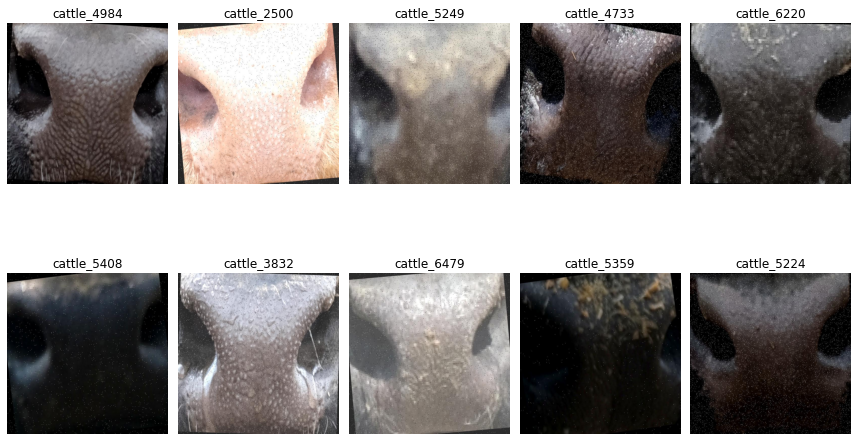

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [134]:
from torch.utils.data import DataLoader

In [135]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [136]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [137]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open("/content/cattle_0200_DSCF3877_jpg.rf.7e3345274194af74b302500454d248cb.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 1.1746e-02, -9.4492e-01,  6.6307e-01,  3.0189e+00,  1.1575e+00,
         1.2423e+00,  2.1915e+00, -1.5803e+00, -1.1623e+00,  1.7610e+00,
        -2.3633e+00, -3.6410e+00, -1.0699e+00,  1.4434e+00, -3.4923e+00,
         1.3265e+00,  5.4079e-02, -4.1198e-02,  3.2471e-01, -2.2310e+00,
         9.7830e-01, -3.3634e-01, -8.7445e-01, -3.3815e-01,  3.5737e+00,
         1.5516e+00,  1.0706e+00,  1.7446e+00,  4.0372e+00,  2.8320e-01,
        -1.3051e+00,  2.6717e-01, -4.2798e-01, -3.1344e+00, -1.2392e+00,
        -9.1939e-01,  2.7398e-01, -6.7918e-01,  2.0588e+00, -1.5040e+00,
         3.4618e+00, -1.2092e+00,  1.0210e-01,  3.8134e+00,  2.1202e+00,
         6.7774e-01, -4.8849e-01, -1.8362e+00,  1.5286e+00,  2.3277e-01,
         1.8612e-01,  4.5578e+00,  1.2664e+00,  1.6555e+00, -1.0195e+00,
        -1.6396e+00, -1.1221e+00, -1.7451e+00, -1.7897e+00, -1.4000e+00,
         1.7752e-01,  3.2809e+00, -1.2173e+00, -2.5933e-01, -1.0054e+00,
         7.4364e-02, -7.1965e-02, -7.1567e-02, -1.2

In [138]:
top1_prob, top1_catid = torch.topk(probabilities, 5)
for i in range(top1_prob.size(0)):
    print(classes[top1_catid[i]], top1_prob[i].item())

cattle_9801 0.8559790849685669
cattle_5408 0.027652112767100334
cattle_0300 0.02220744639635086
cattle_4451 0.02082151733338833
cattle_6226 0.0167929008603096


In [139]:
# import gc
# total_step = len(train_loader)
# num_epochs =50

# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):  
#         # Move tensors to the configured device
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         del images, labels, outputs
#         torch.cuda.empty_cache()
#         gc.collect()

#     print ('Epoch [{}/{}], Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, loss.item()))
            
#     # Validation
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in valid_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             del images, labels, outputs
    
#         print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

In [140]:
# prediction = model("/content/cattle_0200_DSCF3877_jpg.rf.7e3345274194af74b302500454d248cb.jpg")
# model.predict()

In [141]:
# # Set random seeds
# torch.manual_seed(42) 
# torch.cuda.manual_seed(42)

# # Set number of epochs
# NUM_EPOCHS = 5

# # Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# # Start the timer
# from timeit import default_timer as timer 
# start_time = timer()

# # Train model_1
# model_1_results = train(model=model, 
#                         train_dataloader=train_dataloader_augmented,
#                         test_dataloader=test_dataloader_simple,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn, 
#                         epochs=NUM_EPOCHS)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")
